<img src="https://dootoo.app/images/thoughtswork_banner.png"/>

# DataTalks.club MLOps Zoomcamp Final Project: Task Completion Prediction

* **Author:** Paul Tongyoo
* **Contact:** Message me on <a href="https://www.linkedin.com/in/paultongyoo/">LinkedIn</a>
* **Date:** July 7, 2025
* **MLOps Zoomcamp Info:** <a href="https://datatalks.club/blog/mlops-zoomcamp.html">MLOps Zoomcamp: MLOps Course & Certification</a>

## Table of Contents

1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)

In [4]:
import json
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

## Source Data

In [5]:
# Create DB load function for later incorporation into pipeline


def load_latest_db_data():
    """Load data from the database and save it to a Parquet file."""
    load_dotenv()

    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")

    db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
    engine = create_engine(db_url)

    year_ago_cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=1)
    first_done_at = pd.read_sql(
        """
        SELECT MIN("doneAt") AS first_doneAt
        FROM public."Item"
        WHERE "doneAt" IS NOT NULL
        """,
        engine,
    ).iloc[0]["first_doneAt"]
    tasks_df = pd.read_sql(
        """
        SELECT * FROM public.\"Item\" 
        WHERE "createdAt" >= %(cutoff_date)s
          AND "createdAt" >= %(first_doneAt)s
        """,
        engine,
        params={"cutoff_date": year_ago_cutoff_date, "first_doneAt": first_done_at},
    )

    # Save to Parquet file
    print("Saving tasks to Parquet file...")
    tasks_df.to_parquet("dootoo_item_prediction.parquet", index=False)
    print("Tasks saved to dootoo_item_prediction.parquet.")

    return tasks_df

In [6]:
if not os.path.exists("dootoo_item_prediction.parquet"):
    print("Parquet file not found. Loading from database...")
    full_tasks_df = load_latest_db_data()
else:
    print("Loading tasks from Parquet file...")
    full_tasks_df = pd.read_parquet("dootoo_item_prediction.parquet")
    print(f"Loaded {len(full_tasks_df)} tasks from Parquet file.")

Loading tasks from Parquet file...
Loaded 332 tasks from Parquet file.


In [7]:
full_tasks_df.shape

(332, 21)

### Data Set Creation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    full_tasks_df.drop(columns=["is_done"]),
    full_tasks_df["is_done"],
    test_size=0.2,
    random_state=42,
    stratify=full_tasks_df["is_done"],
)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((265, 20), (67, 20), (265,), (67,))

## Exploratory Data Analysis

In [10]:
# Combine X_train and y_train for easier analysis
combined_df = pd.concat([X_train, y_train], axis=1)

### Target Analysis ("is_done")

* Task completion rate is 36.6% completed
* Class imbalance necessitates tuning for both Precision and Recall
    * Model risks bias towards majority (`is_done==0`) class (low recall of `is_done=1`)

Task Completion Rate: 36.6%


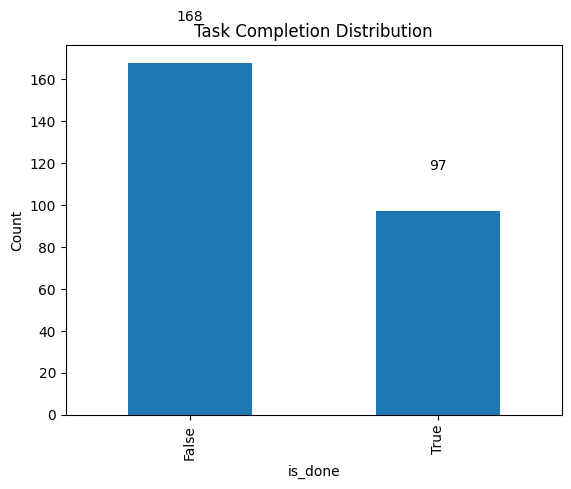

In [11]:
counts = combined_df["is_done"].value_counts()
print(f"Task Completion Rate: {combined_df['is_done'].mean() * 100:.1f}%")
counts.plot(kind="bar", title="Task Completion Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_done")
plt.ylabel("Count")
plt.show()

*  We'll filter data set date range to start from the date of the first task completion to ensure we only model tasks that were created after the task completion feature was made available in the app.
* **First Task Created At:** `2024-11-08 07:26:26`
* **First Task Completed At:** `2025-01-15 13:30:37`

### Parent/Child Status

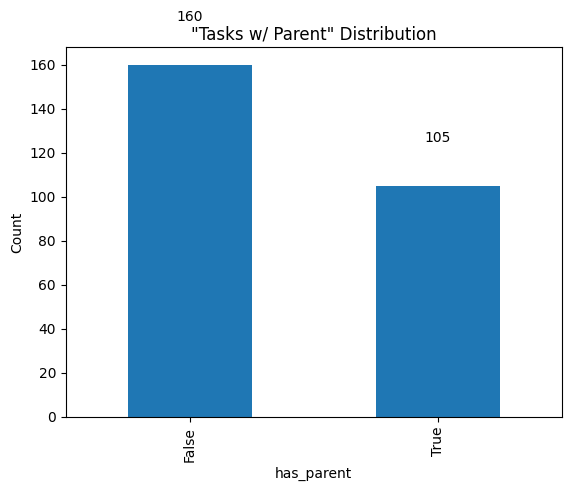

In [12]:
combined_df["has_parent"] = combined_df["parent_item_id"].notnull()
counts = combined_df["has_parent"].value_counts()
counts.plot(kind="bar", title='"Tasks w/ Parent" Distribution')
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("has_parent")
plt.ylabel("Count")
plt.show()

### Task Publicity

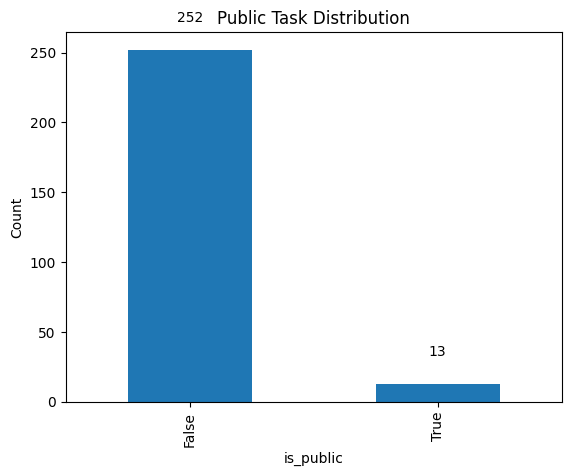

In [13]:
counts = combined_df["is_public"].value_counts()
counts.plot(kind="bar", title="Public Task Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_public")
plt.ylabel("Count")
plt.show()

## Data Preparation

In [14]:
def prepare_data(tasks_df):
    """Prepare the data for modeling."""

    # Extract date and time features from 'createdAt'
    tasks_df["createdAt"] = pd.to_datetime(tasks_df["createdAt"])
    tasks_df["year"] = tasks_df["createdAt"].dt.year
    tasks_df["month"] = tasks_df["createdAt"].dt.month
    tasks_df["day"] = tasks_df["createdAt"].dt.day
    tasks_df["hour"] = tasks_df["createdAt"].dt.hour  # 24-hour format
    tasks_df["day_of_week"] = tasks_df["createdAt"].dt.dayofweek  # 0=Monday, 6=Sunday

    return tasks_df

------

In [18]:
def slugify(text):
    text = text.strip()
    text = re.sub(r"[^\w\s\-]", "", text)  # allow (), - and alphanumerics
    return re.sub(r"[\s]+", "-", text)


def extract_headings(ipynb_path):
    with open(ipynb_path, "r", encoding="utf-8") as f:
        nb = json.load(f)

    toc_lines = []  # ["## Table of Contents\n"]
    for cell in nb["cells"]:
        if cell["cell_type"] == "markdown":
            for line in cell["source"]:
                match = re.match(r"^(#{2,6})\s+(.*)", line)
                if match:
                    level = len(match.group(1)) - 1  # offset for nesting
                    title = match.group(2).strip()
                    anchor = slugify(title)
                    indent = "    " * (level - 1)
                    toc_lines.append(f"{indent}1. [{title}](#{anchor})")

    return "\n".join(toc_lines)


# Example usage:
TOC = extract_headings("dootoo_item_prediction.ipynb")
print(TOC)

1. [Table of Contents](#Table-of-Contents)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)
